## Show

- Making COVID infections, deaths, and infections/death ratio predictions on Metaculus more consistent with each other
- More broadly: a workflow that connects judgmental and model-based forecasting

## Setup

In [ ]:
%%capture
%pip install --quiet poetry  # Fixes https://github.com/python-poetry/poetry/issues/532
%pip install --quiet git+https://github.com/oughtinc/ergo.git@7f88222f5f7a2e552eb1750d43b6c7924d2f0361

In [ ]:
import warnings
warnings.filterwarnings(action="ignore", category=FutureWarning)
warnings.filterwarnings(module="plotnine", action="ignore")
warnings.filterwarnings(module="jax", action="ignore")

In [ ]:
import ergo
import seaborn
import numpy as np

In [ ]:
metaculus = ergo.Metaculus(username="oughtpublic", password="123456")

## Look at questions on Metaculus
* [Total COVID infections before 2021](https://www.metaculus.com/questions/3529/how-many-infections-of-covid-19-will-be-estimated-to-have-occurred-before-2021-50k-1b-range/)
* [Total COVID deaths before 2021](https://www.metaculus.com/questions/3530/how-many-people-will-die-as-a-result-of-the-2019-novel-coronavirus-covid-19-before-2021/)
* [Chance of dying of COVID if you get it](https://www.metaculus.com/questions/3755/what-will-be-the-ratio-of-fatalities-to-total-estimated-infections-for-covid-19-by-the-end-of-2020/)



### Load questions

In [ ]:
q_infections = metaculus.get_question(3529, name="infections")
q_deaths = metaculus.get_question(3530, name="deaths")
q_ratio = metaculus.get_question(3755, name="ratio")

questions = [q_infections, q_deaths, q_ratio]

### Show community estimate for each question

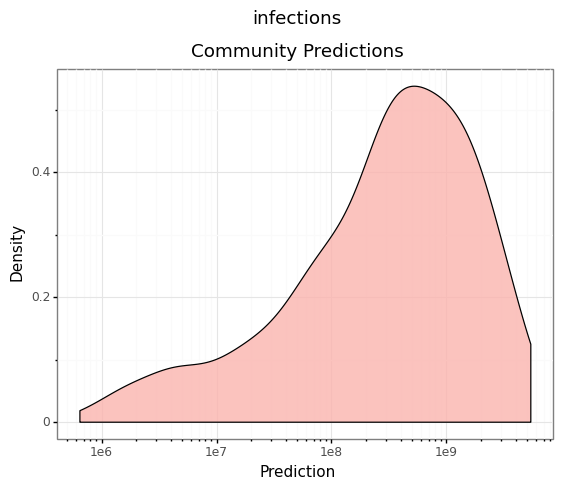

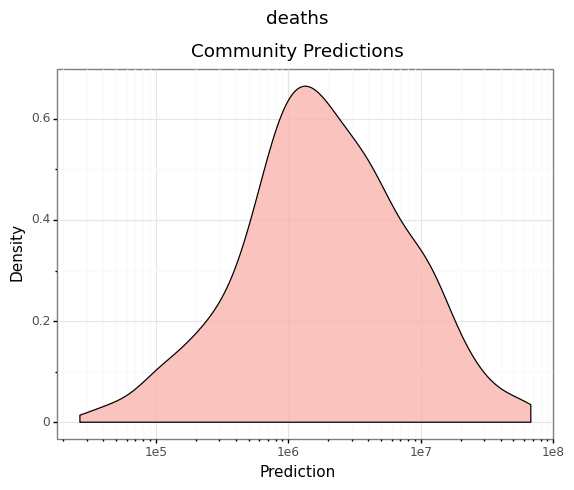

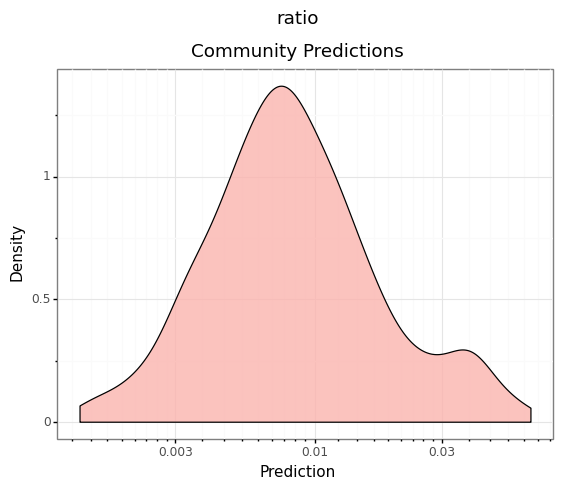

In [7]:
[question.show_community_prediction() for question in questions];

## Model deaths based on the infection and ratio community estimates

Deaths = infections * deaths/infection

In [ ]:
%%capture
def deaths_from_infections():
  infections = q_infections.sample_community()
  ratio = q_ratio.sample_community()
  deaths = infections * ratio
  ergo.tag(deaths, "deaths")
  return deaths

samples = ergo.run(deaths_from_infections, num_samples=5000)

### How does our model prediction compare to the community prediction?

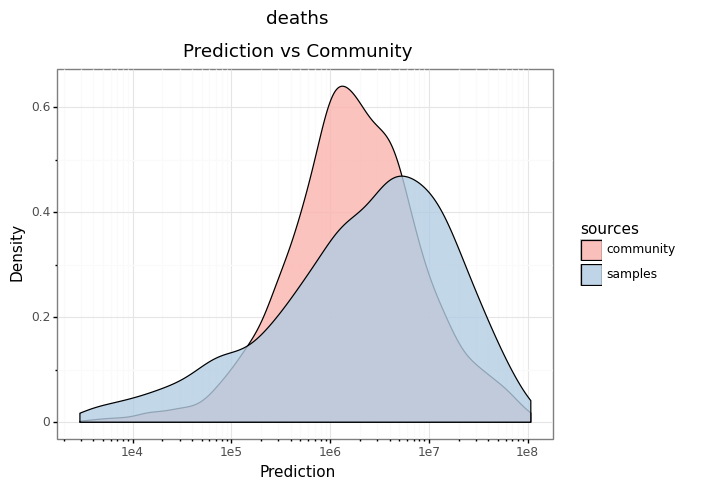

In [9]:
q_deaths.show_prediction(samples["deaths"], show_community=True)

### Combine our model with the community prediction

Mostly defer to the community's predictions on the deaths question, but update a bit towards the model that's based on infections * deaths/infection.

In [ ]:
%%capture
def deaths_adjusted():
  if ergo.flip(.66):
    deaths = q_deaths.sample_community()
  else:
    deaths = deaths_from_infections()
  ergo.tag(deaths, "adjusted_deaths")

samples = ergo.run(deaths_adjusted, num_samples=5000)

adjusted_samples = samples["adjusted_deaths"]

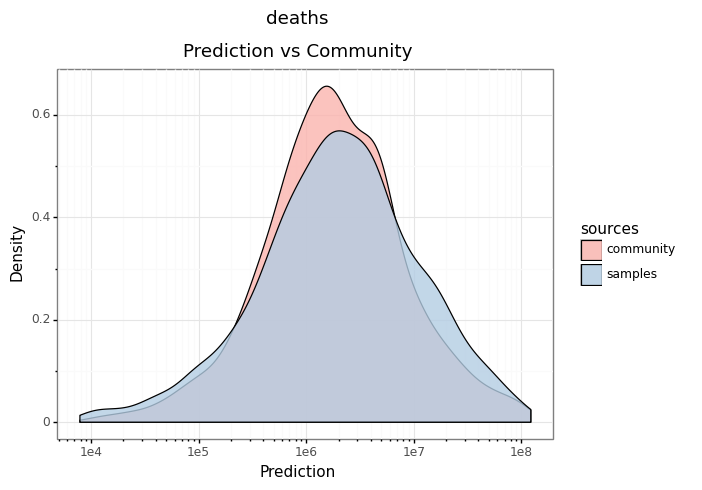

In [11]:
q_deaths.show_prediction(adjusted_samples, show_community=True)

## Submit new distribution on deaths to Metaculus

In [ ]:
%%capture
q_deaths.submit_from_samples(adjusted_samples)

**Exercise:** Apply the same idea to estimating infections from deaths